<a href="https://colab.research.google.com/github/Tizian15/QA-project/blob/main/MdeBERTaFineTuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing all necessary packages for this project.

In [1]:
!pip install transformers datasets torch
!pip install evaluate
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Importing the Dataset via Google Drive (Need to adjust this to your path, whereever you store the "business-questionnaire-dataset")

In [2]:
from google.colab import drive
drive.mount("/content/drive")

from datasets import load_from_disk

dataset_path = "/content/drive/MyDrive/TDS-Project/QA-project/content/business-questionnaire-dataset"

dataset = load_from_disk(dataset_path)
print(dataset)

Mounted at /content/drive
DatasetDict({
    train: Dataset({
        features: ['question', 'context', 'option', 'type', 'answer_length', 'answers_s3auf_mdeberta-v3-squad2-ft-busiQA-3ep', 'score_s3auf_mdeberta-v3-squad2-ft-busiQA-3ep', 'answers_s3auf/bert-finetuned-busiQA', 'score_s3auf/bert-finetuned-busiQA', 'answers_timpal0l/mdeberta-v3-base-squad2', 'score_timpal0l/mdeberta-v3-base-squad2', 'ranked_answer', 'ranked_score'],
        num_rows: 1586
    })
    valid: Dataset({
        features: ['question', 'context', 'option', 'type', 'answer_length', 'answers_s3auf_mdeberta-v3-squad2-ft-busiQA-3ep', 'score_s3auf_mdeberta-v3-squad2-ft-busiQA-3ep', 'answers_s3auf/bert-finetuned-busiQA', 'score_s3auf/bert-finetuned-busiQA', 'answers_timpal0l/mdeberta-v3-base-squad2', 'score_timpal0l/mdeberta-v3-base-squad2', 'ranked_answer', 'ranked_score'],
        num_rows: 680
    })
})


In [3]:
train_df = dataset["train"].to_pandas()
valid_df = dataset["valid"].to_pandas()

train_df[["question", "ranked_answer"]].head(10)

,question,ranked_answer
0,What are your primary concerns about implement...,"{'answer': ' providing effective training', 'a..."
1,Which training methods are you planning to imp...,"{'answer': ' gamified learning elements', 'ans..."
2,What are your biggest challenges in online adv...,{'answer': ' finding qualified traffic and the...
3,"On a scale of 1 to 10, how would you rate the ...","{'answer': ' 2', 'answer_start': 50, 'model': ..."
4,Which sustainability initiatives has your comp...,{'answer': ' reducing water consumption throug...
5,What is your company's primary industry?,"{'answer': ' healthcare', 'answer_start': 31, ..."
6,What is your company’s annual revenue?,"{'answer': ' $10 million to $50 million', 'ans..."
7,What CRM platforms have you previously conside...,"{'answer': ' HubSpot and Zoho CRM.', 'answer_s..."
8,What are your company's main obstacles to achi...,"{'answer': ' lack of employee engagement', 'an..."
9,How many employees have access to sensitive co...,"{'answer': ' 7', 'answer_start': 15, 'model': ..."


Extract answer and answer_start from ranked_answer column


In [4]:
import ast  # Needed to convert string representations of dictionaries

# Function to extract answer and answer_start from the "ranked_answer" column
def extract_answer_info(row):
    answer_data = row["ranked_answer"]
    if isinstance(answer_data, str):  # Convert string to dictionary if necessary
        answer_data = ast.literal_eval(answer_data)
    return answer_data["answer"], answer_data["answer_start"]

# Apply the function to extract relevant data
train_df["answer"], train_df["answer_start"] = zip(*train_df.apply(extract_answer_info, axis=1))

# Display the first few rows to verify the extraction
train_df[["question", "context", "answer", "answer_start"]].head(5)

,question,context,answer,answer_start
0,What are your primary concerns about implement...,Our primary concern regarding the implementati...,providing effective training,83
1,Which training methods are you planning to imp...,"For next year, we're focusing on enhancing our...",gamified learning elements,110
2,What are your biggest challenges in online adv...,Our two biggest challenges in online advertisi...,finding qualified traffic and the lack of tim...,52
3,"On a scale of 1 to 10, how would you rate the ...",I'd rate the ease of use of our current softwa...,2,50
4,Which sustainability initiatives has your comp...,We've implemented a variety of sustainability ...,reducing water consumption through improved t...,70


Check for missing values in extracted columns

In [5]:
missing_values = train_df[["question", "context", "answer", "answer_start"]].isna().sum()
missing_values

,0
question,0
context,0
answer,0
answer_start,0


Visualize answer length distribution

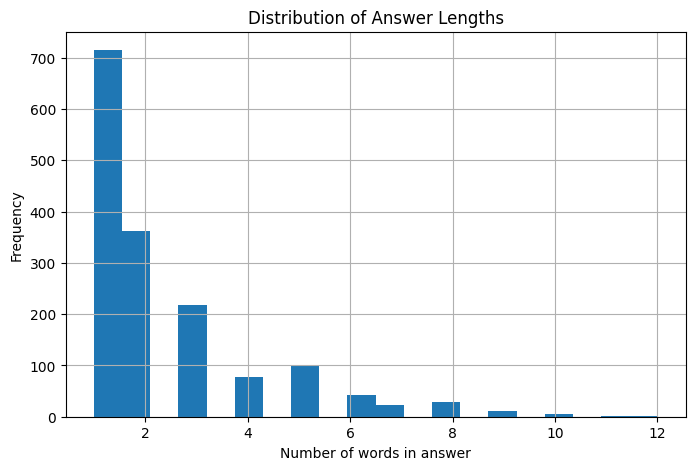

In [6]:
import matplotlib.pyplot as plt

# Calculate answer length in words
train_df["answer_length"] = train_df["answer"].apply(lambda x: len(str(x).split()))

# Plot the distribution of answer lengths
plt.figure(figsize=(8,5))
train_df["answer_length"].hist(bins=20)
plt.xlabel("Number of words in answer")
plt.ylabel("Frequency")
plt.title("Distribution of Answer Lengths")
plt.show()

Load *tokenizer* for model mdberta-v3-base



In [7]:
from transformers import AutoTokenizer

# Load a tokenizer for the chosen model
MODEL_NAME = "microsoft/mdeberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Converting answer_start to Token positions

In [8]:
# Function to tokenize question and context, and find token positions of the answer
def preprocess_data(examples):
    tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        truncation=True,
        padding="max_length",
        max_length=512,
        return_offsets_mapping=True,
        return_tensors="pt"
    )

    # Find token positions for the answer
    start_positions = []
    end_positions = []

    for i, offsets in enumerate(tokenized_examples["offset_mapping"]):
        answer_start = examples["answer_start"][i]
        answer_end = answer_start + len(examples["answer"][i])

        # Locate the token positions
        start_token, end_token = None, None
        for j, (start, end) in enumerate(offsets):
            if start <= answer_start < end:
                start_token = j
            if start < answer_end <= end:
                end_token = j
                break

        # Handle cases where answer_start is out of tokenized range
        if start_token is None or end_token is None:
            start_token = 0
            end_token = 0

        start_positions.append(start_token)
        end_positions.append(end_token)

    tokenized_examples["start_positions"] = start_positions
    tokenized_examples["end_positions"] = end_positions

    return tokenized_examples

Applying the preprocessing to our dataset

In [9]:
from datasets import Dataset

# Convert pandas DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df[["question", "context", "answer", "answer_start"]])

# Apply tokenization function
tokenized_train_dataset = train_dataset.map(preprocess_data, batched=True)

# Get the available columns in the dataset
existing_columns = tokenized_train_dataset.column_names

# Define columns that should be removed if they exist
columns_to_remove = ["question", "context", "answer", "answer_start", "__index_level_0__"]

# Remove only the columns that are actually in the dataset
tokenized_train_dataset = tokenized_train_dataset.remove_columns([col for col in columns_to_remove if col in existing_columns])

# Check the remaining columns
print(tokenized_train_dataset.column_names)

Map:   0%|          | 0/1586 [00:00<?, ? examples/s]

['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'start_positions', 'end_positions']


Extract answer and answer_start for Validation Set

In [10]:
import ast

# Function to extract answer and answer_start from the "ranked_answer" column
def extract_answer_info(row):
    answer_data = row["ranked_answer"]
    if isinstance(answer_data, str):  # Convert string to dictionary if necessary
        answer_data = ast.literal_eval(answer_data)
    return answer_data["answer"], answer_data["answer_start"]

# Apply the function to extract relevant data for validation set
valid_df["answer"], valid_df["answer_start"] = zip(*valid_df.apply(extract_answer_info, axis=1))

Tokenize the validation dataset

In [11]:
valid_dataset = Dataset.from_pandas(valid_df[["question", "context", "answer", "answer_start"]])
tokenized_valid_dataset = valid_dataset.map(preprocess_data, batched=True)

# Remove unnecessary columns
existing_columns = tokenized_valid_dataset.column_names
columns_to_remove = ["question", "context", "answer", "answer_start", "__index_level_0__"]
tokenized_valid_dataset = tokenized_valid_dataset.remove_columns([col for col in columns_to_remove if col in existing_columns])

Map:   0%|          | 0/680 [00:00<?, ? examples/s]

Load pretrained QA Model from HuggingFace (deberta-v3-large)

In [12]:
from transformers import AutoModelForQuestionAnswering

# Load the pre-trained model for Question Answering
model = AutoModelForQuestionAnswering.from_pretrained("microsoft/mdeberta-v3-base")

pytorch_model.bin:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of DebertaV2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Defining training arguments

In [13]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./qa_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,  # Reduce batch size to save memory
    per_device_eval_batch_size=16,  # Also reduce for validation
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    push_to_hub=False,
    report_to="none",
    fp16=True  # Enable mixed precision training

)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Disabling wandb

In [14]:
import os
os.environ["WANDB_DISABLED"] = "true"

Set up Trainer and start with the Training

In [15]:
from transformers import Trainer, DataCollatorWithPadding

# Use a data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_valid_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

# Start training
trainer.train()


<ipython-input-15-dca9349febf8>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.385900,1.925741
2,1.613300,1.644035
3,1.383300,1.626549


TrainOutput(global_step=300, training_loss=2.087882029215495, metrics={'train_runtime': 109.4783, 'train_samples_per_second': 43.461, 'train_steps_per_second': 2.74, 'total_flos': 1243272419610624.0, 'train_loss': 2.087882029215495, 'epoch': 3.0})

I saved the fine tuned model to Google Drive so I dont have to run this code ever again.